In [1]:
##!python
#!/usr/bin/env python

import os
import shutil
from scipy.io import loadmat
import numpy as np
import scipy.io
from operator import itemgetter
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2 
from tqdm import tqdm
import tensorflow as tf
%matplotlib inline

In [2]:
"""
matph = './mpii.mat'
mat = loadmat(matph, struct_as_record=False)

mat

release = loadmat(matph, struct_as_record=False)["RELEASE"]

print(release, type(release), release.shape)

object1 = release[0,0]
print(object1._fieldnames)

print(release.shape[0])
testdi = release[0]
print(testdi.shape[0])
testdi[0]


annolist = object1.__dict__['annolist']
print(annolist, type(annolist), annolist.shape)

#vemos el obj 4 (Contiene información de 2 personas)
anno1 = annolist[0,4]
print(anno1._fieldnames)

annorect = anno1.__dict__['annorect']
print(annorect, type(annorect), annorect.shape)

anno2 = annorect[0,0]
print(anno2._fieldnames)

objpos = anno2.__dict__['objpos']
print(objpos, type(objpos), objpos.shape)

objpos1 = objpos[0,0]
print(objpos1._fieldnames)

y = objpos1.__dict__['y']
print(y, type(y), y.shape)
"""

'\nmatph = \'./mpii.mat\'\nmat = loadmat(matph, struct_as_record=False)\n\nmat\n\nrelease = loadmat(matph, struct_as_record=False)["RELEASE"]\n\nprint(release, type(release), release.shape)\n\nobject1 = release[0,0]\nprint(object1._fieldnames)\n\nprint(release.shape[0])\ntestdi = release[0]\nprint(testdi.shape[0])\ntestdi[0]\n\n\nannolist = object1.__dict__[\'annolist\']\nprint(annolist, type(annolist), annolist.shape)\n\n#vemos el obj 4 (Contiene información de 2 personas)\nanno1 = annolist[0,4]\nprint(anno1._fieldnames)\n\nannorect = anno1.__dict__[\'annorect\']\nprint(annorect, type(annorect), annorect.shape)\n\nanno2 = annorect[0,0]\nprint(anno2._fieldnames)\n\nobjpos = anno2.__dict__[\'objpos\']\nprint(objpos, type(objpos), objpos.shape)\n\nobjpos1 = objpos[0,0]\nprint(objpos1._fieldnames)\n\ny = objpos1.__dict__[\'y\']\nprint(y, type(y), y.shape)\n'

# Limpieza de Datos

In [3]:
#darle formato de diccionario
matph = './mpii.mat'
decoded1 = loadmat(matph, struct_as_record=False)["RELEASE"]
must_be_list_fields = ["annolist","image","name", "annorect", "scale", "x", "y", "annopoints", "point", "id"]

In [4]:
def generate_dataset_obj(obj):
    if type(obj) == np.ndarray:
        dim = obj.shape[0]
        if dim == 1:
            ret = generate_dataset_obj(obj[0])             
        else:
            ret = []
            for i in range(dim):
                ret.append(generate_dataset_obj(obj[i]))                

    elif type(obj) == scipy.io.matlab.mio5_params.mat_struct:
        ret = {}
        for field_name in obj._fieldnames:            
            field = generate_dataset_obj(obj.__dict__[field_name])
            if field_name in must_be_list_fields:
                field = [field]
                ret[field_name] = field

    else:
        ret = obj

    return ret

In [5]:
def print_dataset_obj(obj, depth = 0, maxIterInArray = 20):
    prefix = "  "*depth
    if type(obj) == dict:
        for key in obj.keys():
            print("{}{}".format(prefix, key))
            print_dataset_obj(obj[key], depth + 1)
    elif type(obj) == list:
        for i, value in enumerate(obj):
            if i >= maxIterInArray:
                break
            print("{}{}".format(prefix, i))
            print_dataset_obj(value, depth + 1)
    else:
        print("{}{}".format(prefix, obj))

# Convert to dict
dataset_obj = generate_dataset_obj(decoded1)

In [6]:
# Print it out
#print_dataset_obj(dataset_obj)

In [7]:
len(dataset_obj['annolist'][0])
dataset = dataset_obj['annolist'][0]

In [8]:
#guarda solo informacion de las imagenes que tienen solo una persona
train_data1 = [] #guarda toda la información, solo para ver 
train_data2 = []
for i in range(len(dataset)):
    if "annopoints" in dataset[i]['annorect'][0]:          
        train_data1.append(dataset[i])         
        name = dataset[i]['image'][0]['name'][0]
        tupla = [] 
        for j in range(16):     #ordena los puntos de articulaciones del id = 0 al id = 15       
            try:
                x = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['x'][0]
            except:
                x = -1
            try:
                y = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['y'][0]
            except:
                y = -1
            try:
                id = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['id'][0]
            except:
                id = -1          
            tupla.append((x,y,id))
        tupla = sorted(tupla, key = itemgetter(2))
        for j in range(len(tupla)):   #quita id de las tuplas
            tupla[j] = tupla[j][:2]
        train_data2.append((name,tupla))

In [9]:
#len(train_data2)
names = []
for item in train_data2:#guardar nombres de las imagenes que voy a usar en "name"
    names.append(item[0])

In [10]:
#train_data2
#names
def return_image_joints(name,data):
    for item in data: # guardar coordenadas de los joints
        if item[0] == name:
            #print(item[1]) 
            return item[1]

In [11]:
train_data2[0]

('060111501.jpg',
 [(980, 322),
  (896, 318),
  (865, 248),
  (943, 226),
  (948, 290),
  (881, 349),
  (904, 237),
  (858, 135),
  (871.1877, 180.4244),
  (835.8123, 58.5756),
  (772, 294),
  (754, 247),
  (792, 147),
  (923, 123),
  (995, 163),
  (961, 223)])

In [12]:
Path_To_Raw_Images = 'DataSet/mpii_human_pose_v1_images'
Path_To_Single_Person_Images = 'DataSet/mpii_human_pose_v1_images/SinglePersonImagesWithData'
os.chdir(Path_To_Raw_Images)

if os.path.isdir('SinglePersonImagesWithData') is False:
    os.makedirs('SinglePersonImagesWithData')
    for images in names:
        shutil.move(images, 'SinglePersonImagesWithData')
        
os.chdir('../../')

In [13]:
rightconnections = [(0,1),(1,2),(3,4),(4,5),(2,6),(3,6),(6,7),(7,8),(8,9),(10,11),(11,12),(12,7),(13,7),(13,14),(14,15)]
def draw_img_joints(file_name, data, img ):    
    # Load image
    #img = cv2.imread(Path_To_Single_Person_Images + "/" + file_name,1)
       
      
    pts = return_image_joints(file_name, data)        
    #plt.imshow(img)  
    X = [x[0] for x in pts]
    Y = [y[1] for y in pts]
    X = [int(x) for x in X]
    Y = [int(y) for y in Y]
    """
    plt.scatter(X, Y, marker="o", color="red", s=20)    
    #pierna derecha
    img = cv2.line(img,(X[0],Y[0]),(X[1],Y[1]),(1,0,0),5)
    img = cv2.line(img,(X[1],Y[1]),(X[2],Y[2]),(1,0,0),5)
    #pierna izquierda
    img = cv2.line(img,(X[3],Y[3]),(X[4],Y[4]),(1,0,0),5)
    img = cv2.line(img,(X[4],Y[4]),(X[5],Y[5]),(1,0,0),5)
    #cintura
    img = cv2.line(img,(X[2],Y[2]),(X[6],Y[6]),(1,0,0),5)
    img = cv2.line(img,(X[3],Y[3]),(X[6],Y[6]),(1,0,0),5)
    #union cintura torax
    img = cv2.line(img,(X[6],Y[6]),(X[7],Y[7]),(1,0,0),5)
    #torax a cuello
    img = cv2.line(img,(X[7],Y[7]),(X[8],Y[8]),(1,0,0),5)
    #cuello a cabeza
    img = cv2.line(img,(X[8],Y[8]),(X[9],Y[9]),(1,0,0),5)
    #brazo derecho
    img = cv2.line(img,(X[10],Y[10]),(X[11],Y[11]),(1,0,0),5)
    img = cv2.line(img,(X[11],Y[11]),(X[12],Y[12]),(1,0,0),5)
    img = cv2.line(img,(X[12],Y[12]),(X[7],Y[7]),(1,0,0),5)
    #brazo izquierdo
    img = cv2.line(img,(X[13],Y[13]),(X[7],Y[7]),(1,0,0),5)
    img = cv2.line(img,(X[13],Y[13]),(X[14],Y[14]),(1,0,0),5)
    img = cv2.line(img,(X[14],Y[14]),(X[15],Y[15]),(1,0,0),5)
    plt.imshow(img)
    """
    for i in range(16):
        for j in range(16):
            if (i,j) in rightconnections:
                if X[i]>0 and X[j]>0 and Y[i]>0 and Y[j]>0:
                    img = cv2.line(img,(X[i],Y[i]),(X[j],Y[j]),(1,0,0),5)
                    plt.scatter(X[i], Y[i], marker="o", color="red", s=20)
                    plt.scatter(X[j], Y[j], marker="o", color="red", s=20)
                    
    plt.imshow(img)

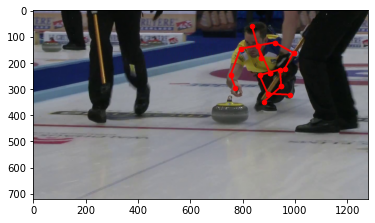

In [14]:
#Demostración dibujar joints en imagenes con data
img = image.load_img(Path_To_Single_Person_Images + "/" + '060111501.jpg')
img = image.img_to_array(img) 
img = img/255
draw_img_joints('060111501.jpg',train_data2, img)

In [15]:
#Ahora cargamos las imagenes
size_img_x = 200
size_img_y = 200
def load_image(train_data, a, b):
    train = list(train_data[a:b])
    train_image = []
    for i in tqdm(range(a,b)):
        name_img = train[i][0]
        img = image.load_img(Path_To_Single_Person_Images + '/' + name_img)
        img = image.img_to_array(img)
        img_x = img.shape[1]
        img_y = img.shape[0]
        scala_x = img_x / size_img_x
        scala_y = img_y / size_img_y
        for j in range(len(train[i][1])):
            train[i][1][j] = (train[i][1][j][0] / scala_x, train[i][1][j][1] / scala_y)
        img = tf.image.resize(img,(size_img_x, size_img_y))        
        img = img/255
        train_image.append(img)
    return train, train_image

In [16]:
lista_de_joints, lista_de_imagenes = load_image(train_data2,0,9000)

100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [05:01<00:00, 29.86it/s]


In [20]:
lista_de_joints[1]

('002058449.jpg',
 [(143.4375, 126.66666666666666),
  (102.96875, 143.88888888888889),
  (111.40625, 114.72222222222221),
  (152.96875, 80.0),
  (190.9375, 125.83333333333333),
  (152.1875, 110.83333333333333),
  (132.1875, 97.5),
  (115.3125, 71.94444444444444),
  (124.26153125, 87.47047222222223),
  (93.39471874999998, 33.918416666666666),
  (68.90625, 136.11111111111111),
  (69.6875, 120.55555555555556),
  (93.59375, 75.0),
  (137.03125, 68.61111111111111),
  (173.75, 106.66666666666666),
  (158.125, 135.83333333333334)])

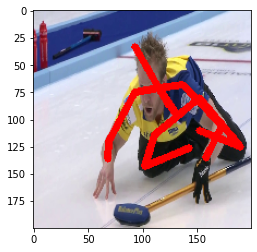

In [21]:
draw_img_joints('002058449.jpg',lista_de_joints, np.float32(lista_de_imagenes[1]))

# RED NEURONAL